# 12 - Estimation Doublement Robuste

## Ne Mettez Pas Tous Vos Œufs dans le Même Panier

Nous avons appris à utiliser la régression linéaire et la pondération par score de propension pour estimer $E[Y|T=1] - E[Y|T=0] | X$. Mais laquelle de ces méthodes devrions-nous utiliser, et quand ? En cas de doute, utilisez simplement les deux ! L'estimation doublement robuste est une méthode qui combine le score de propension et la régression linéaire de manière à ne pas avoir à se fier entièrement à l'une ou l'autre méthode.

Pour comprendre comment cela fonctionne, considérons l'expérience sur le mindset. Il s'agit d'une étude randomisée menée dans des lycées publics aux États-Unis, visant à évaluer l'impact du mindset de croissance. Les élèves reçoivent un séminaire de la part de l'école pour leur inculquer un mindset de croissance. Ensuite, on les suit pendant leurs années de collège pour mesurer leurs performances académiques. Cette mesure a été compilée en un score de réussite et standardisée. Les données réelles de cette étude ne sont pas disponibles publiquement afin de préserver la confidentialité des élèves. Cependant, nous disposons d'un ensemble de données simulées avec les mêmes propriétés statistiques, fourni par [Athey et Wager](https://arxiv.org/pdf/1902.07409.pdf), que nous allons utiliser à la place.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression, LinearRegression

%matplotlib inline

style.use("fivethirtyeight")
pd.set_option("display.max_columns", 6)

In [2]:
data = pd.read_csv("./data/learning_mindset.csv")
data.sample(5, random_state=5)

,schoolid,intervention,achievement_score,...,school_ethnic_minority,school_poverty,school_size
259,73,1,1.480828,...,-0.515202,-0.169849,0.173954
3435,76,0,-0.987277,...,-1.310927,0.224077,-0.426757
9963,4,0,-0.152340,...,0.875012,-0.724801,0.761781
4488,67,0,0.358336,...,0.315755,0.054586,1.862187
2637,16,1,1.360920,...,-0.033161,-0.982274,1.591641


Bien que l'étude ait été randomisée, il ne semble pas que ces données soient exemptes de facteurs de confusion. Une des raisons possibles à cela est que la variable de traitement est mesurée par la participation des élèves au séminaire. Ainsi, bien que l'opportunité de participer ait été aléatoire, la participation elle-même ne l'est pas. Nous sommes ici confrontés à un cas de non-conformité. Une preuve de cela est que les attentes de réussite des élèves sont corrélées avec leur participation au séminaire. Les élèves qui se déclarent avoir des attentes élevées sont plus susceptibles d'avoir rejoint le séminaire sur le mindset de croissance.

In [3]:
data.groupby("success_expect")["intervention"].mean()

success_expect
1    0.271739
2    0.265957
3    0.294118
4    0.271617
5    0.311070
6    0.354287
7    0.362319
Name: intervention, dtype: float64

Comme nous le savons maintenant, nous pourrions ajuster cela en utilisant une régression linéaire ou en estimant un modèle de score de propension avec une régression logistique. Cependant, avant de faire cela, nous devons convertir les variables catégorielles en variables dummies.

In [4]:
categ = ["ethnicity", "gender", "school_urbanicity"]
cont = ["school_mindset", "school_achievement", "school_ethnic_minority", "school_poverty", "school_size"]

data_with_categ = pd.concat([
    data.drop(columns=categ), # dataset without the categorical features
    pd.get_dummies(data[categ], columns=categ, drop_first=False) # categorical features converted to dummies
], axis=1)

print(data_with_categ.shape)

(10391, 32)


Nous sommes maintenant prêts à comprendre comment fonctionne l'estimation doublement robuste.

## Estimation Doublement Robuste (*Doubly Robust*)

![img](./data/img/doubly-robust/double.png)

Au lieu de dériver l'estimateur, je vais d'abord vous le montrer, puis expliquer pourquoi il est si impressionnant.

$$
\hat{ATE} = \frac{1}{N}\sum \bigg( \dfrac{T_i(Y_i - \hat{\mu_1}(X_i))}{\hat{P}(X_i)} + \hat{\mu_1}(X_i) \bigg) - \frac{1}{N}\sum \bigg( \dfrac{(1-T_i)(Y_i - \hat{\mu_0}(X_i))}{1-\hat{P}(X_i)} + \hat{\mu_0}(X_i) \bigg)
$$

où $\hat{P}(x)$ est une estimation du score de propension (en utilisant par exemple une régression logistique), $\hat{\mu_1}(x)$ est une estimation de $E[Y|X, T=1]$ (en utilisant par exemple une régression linéaire), et $\hat{\mu_0}(x)$ est une estimation de $E[Y|X, T=0]$. Comme vous l'avez peut-être déjà deviné, la première partie de l'estimateur doublement robuste estime $E[Y_1]$ et la deuxième partie estime $E[Y_0]$. Examinons la première partie, car toute l'intuition s'appliquera également à la deuxième partie par analogie.

Je sais que cette formule peut sembler intimidante au premier abord (mais ne vous inquiétez pas, vous verrez que c'est en réalité très simple). Je vais d'abord montrer comment coder cet estimateur. J'ai le sentiment que certaines personnes sont moins effrayées par du code que par des formules. Voyons comment cet estimateur fonctionne en pratique, d'accord ?

In [5]:
def doubly_robust(df, X, T, Y):
    ps = LogisticRegression(C=1e6, max_iter=1000).fit(df[X], df[T]).predict_proba(df[X])[:, 1]
    mu0 = LinearRegression().fit(df.query(f"{T}==0")[X], df.query(f"{T}==0")[Y]).predict(df[X])
    mu1 = LinearRegression().fit(df.query(f"{T}==1")[X], df.query(f"{T}==1")[Y]).predict(df[X])
    return (
        np.mean(df[T]*(df[Y] - mu1)/ps + mu1) -
        np.mean((1-df[T])*(df[Y] - mu0)/(1-ps) + mu0)
    )

In [6]:
T = 'intervention'
Y = 'achievement_score'
X = data_with_categ.columns.drop(['schoolid', T, Y])

doubly_robust(data_with_categ, X, T, Y)

0.38822121767832457

L'estimateur doublement robuste indique que nous devrions nous attendre à ce que les individus ayant assisté au séminaire sur le mindset soient 0,388 écart-type au-dessus de leurs homologues non traités en termes de réussite. Une fois de plus, nous pouvons utiliser le bootstrap pour construire des intervalles de confiance.

In [7]:
from joblib import Parallel, delayed # for parallel processing

np.random.seed(88)
# run 1000 bootstrap samples
bootstrap_sample = 1000
ates = Parallel(n_jobs=4)(delayed(doubly_robust)(data_with_categ.sample(frac=1, replace=True), X, T, Y)
                          for _ in range(bootstrap_sample))
ates = np.array(ates)

In [8]:
print(f"ATE 95% CI:", (np.percentile(ates, 2.5), np.percentile(ates, 97.5)))

ATE 95% CI: (0.35364752721776144, 0.41978441342477585)


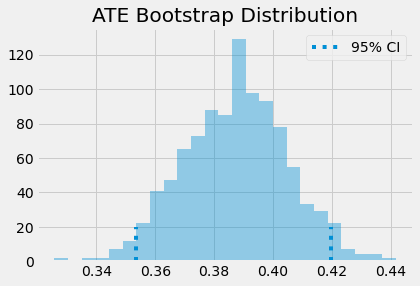

In [9]:
sns.distplot(ates, kde=False)
plt.vlines(np.percentile(ates, 2.5), 0, 20, linestyles="dotted")
plt.vlines(np.percentile(ates, 97.5), 0, 20, linestyles="dotted", label="95% CI")
plt.title("ATE Bootstrap Distribution")
plt.legend();

Maintenant que nous avons un aperçu de l'estimateur doublement robuste, examinons pourquoi il est si performant. Il est appelé "doublement robuste" parce qu'il ne nécessite qu'un seul des modèles, $\hat{P}(x)$ ou $\hat{\mu}(x)$, pour être correctement spécifié. Pour comprendre cela, prenons la première partie qui estime $E[Y_1]$ et examinons-la attentivement.

$$
\hat{E}[Y_1] = \frac{1}{N}\sum \bigg( \dfrac{T_i(Y_i - \hat{\mu_1}(X_i))}{\hat{P}(X_i)} + \hat{\mu_1}(X_i) \bigg)
$$

Supposons que $\hat{\mu_1}(x)$ soit correct. Si le modèle de score de propension est erroné, nous n'avons pas à nous en inquiéter. En effet, si $\hat{\mu_1}(x)$ est correct, alors $E[T_i(Y_i - \hat{\mu_1}(X_i))]=0$. Cela est dû au fait que la multiplication par $T_i$ sélectionne uniquement les traités, et le résidu de $\hat{\mu_1}$ sur les traités a, par définition, une moyenne de zéro. Cela fait que l'expression se réduit à $\hat{\mu_1}(X_i)$, qui estime correctement $E[Y_1]$ par hypothèse. Vous voyez donc que si $\hat{\mu_1}(X_i)$ est correct, il élimine la pertinence du modèle de score de propension. Nous pouvons appliquer le même raisonnement pour comprendre l'estimateur de $E[Y_0]$.

Mais ne me croyez pas sur parole, laissez le code vous montrer la voie ! Dans l'estimateur suivant, j'ai remplacé la régression logistique qui estime le score de propension par une variable aléatoire uniforme allant de 0,1 à 0,9 (je ne veux pas que des poids très faibles fassent exploser la variance du score de propension). Puisque cela est aléatoire, il n'y a aucune chance que ce soit un bon modèle de score de propension, mais nous verrons que l'estimateur doublement robuste parvient tout de même à produire une estimation très proche de celle obtenue lorsque le score de propension était estimé avec la régression logistique.

In [10]:
from sklearn.linear_model import LogisticRegression, LinearRegression

def doubly_robust_wrong_ps(df, X, T, Y):
    # wrong PS model
    np.random.seed(654)
    ps = np.random.uniform(0.1, 0.9, df.shape[0])
    mu0 = LinearRegression().fit(df.query(f"{T}==0")[X], df.query(f"{T}==0")[Y]).predict(df[X])
    mu1 = LinearRegression().fit(df.query(f"{T}==1")[X], df.query(f"{T}==1")[Y]).predict(df[X])
    return (
        np.mean(df[T]*(df[Y] - mu1)/ps + mu1) -
        np.mean((1-df[T])*(df[Y] - mu0)/(1-ps) + mu0)
    )

In [11]:
doubly_robust_wrong_ps(data_with_categ, X, T, Y)

0.3797369830995927

Si nous utilisons le bootstrap, nous pouvons constater que la variance est légèrement plus élevée que lorsque le score de propension était estimé par une régression logistique.

In [12]:
np.random.seed(88)
parallel_fn = delayed(doubly_robust_wrong_ps)
wrong_ps = Parallel(n_jobs=4)(parallel_fn(data_with_categ.sample(frac=1, replace=True), X, T, Y)
                              for _ in range(bootstrap_sample))
wrong_ps = np.array(wrong_ps)

In [13]:
print(f"Original ATE 95% CI:", (np.percentile(ates, 2.5), np.percentile(ates, 97.5)))

print(f"Wrong PS ATE 95% CI:", (np.percentile(wrong_ps, 2.5), np.percentile(wrong_ps, 97.5)))

Original ATE 95% CI: (0.35364752721776144, 0.41978441342477585)
Wrong PS ATE 95% CI: (0.33806443306747086, 0.4335673822553228)


Comme nous pouvons le voir, altérer le score de propension produit des ATE légèrement différents, mais pas de manière significative. Cela couvre le cas où le modèle de propension est incorrect, mais le modèle de résultat est correct. Qu'en est-il de l'autre situation ? Prenons à nouveau un bon coup d'œil à la première partie de l'estimateur, mais réarrangeons certains termes :

$$
\hat{E}[Y_1] = \frac{1}{N}\sum \bigg( \dfrac{T_i(Y_i - \hat{\mu_1}(X_i))}{\hat{P}(X_i)} + \hat{\mu_1}(X_i) \bigg)
$$

$$
\hat{E}[Y_1] = \frac{1}{N}\sum \bigg( \dfrac{T_iY_i}{\hat{P}(X_i)} - \dfrac{T_i\hat{\mu_1}(X_i)}{\hat{P}(X_i)} + \hat{\mu_1}(X_i) \bigg)
$$

$$
\hat{E}[Y_1] = \frac{1}{N}\sum \bigg( \dfrac{T_iY_i}{\hat{P}(X_i)} - \bigg(\dfrac{T_i}{\hat{P}(X_i)} - 1\bigg) \hat{\mu_1}(X_i) \bigg)
$$

$$
\hat{E}[Y_1] = \frac{1}{N}\sum \bigg( \dfrac{T_iY_i}{\hat{P}(X_i)} - \bigg(\dfrac{T_i - \hat{P}(X_i)}{\hat{P}(X_i)}\bigg) \hat{\mu_1}(X_i) \bigg)
$$

Maintenant, supposons que le score de propension $\hat{P}(X_i)$ soit correctement spécifié. Dans ce cas, $E[T_i - \hat{P}(X_i)]=0$, ce qui annule la partie dépendante de $\hat{\mu_1}(X_i)$. Cela réduit l'estimateur doublement robuste à l'estimateur de pondération par score de propension $\frac{T_iY_i}{\hat{P}(X_i)}$, qui est correct par hypothèse. Ainsi, même si $\hat{\mu_1}(X_i)$ est incorrect, l'estimateur sera toujours correct, à condition que le score de propension soit correctement spécifié.

Encore une fois, si vous faites davantage confiance au code qu'aux formules, voici une vérification pratique. Dans le code ci-dessous, j'ai remplacé les deux modèles de régression par une variable normale aléatoire. Il ne fait aucun doute que $\hat{\mu}(X_i)$ **n'est pas correctement spécifié**. Pourtant, nous verrons que l'estimation doublement robuste parvient toujours à retrouver le même $\hat{ATE}$ d'environ 0,38 que nous avons vu précédemment.

In [14]:
from sklearn.linear_model import LogisticRegression, LinearRegression

def doubly_robust_wrong_model(df, X, T, Y):
    np.random.seed(654)
    ps = LogisticRegression(C=1e6, max_iter=1000).fit(df[X], df[T]).predict_proba(df[X])[:, 1]
    
    # wrong mu(x) model
    mu0 = np.random.normal(0, 1, df.shape[0])
    mu1 = np.random.normal(0, 1, df.shape[0])
    return (
        np.mean(df[T]*(df[Y] - mu1)/ps + mu1) -
        np.mean((1-df[T])*(df[Y] - mu0)/(1-ps) + mu0)
    )

In [15]:
doubly_robust_wrong_model(data_with_categ, X, T, Y)

0.39811864040982625

Encore une fois, nous pouvons utiliser le bootstrap et constater que la variance est seulement légèrement plus élevée.

In [16]:
np.random.seed(88)
parallel_fn = delayed(doubly_robust_wrong_model)
wrong_mux = Parallel(n_jobs=4)(parallel_fn(data_with_categ.sample(frac=1, replace=True), X, T, Y)
                               for _ in range(bootstrap_sample))
wrong_mux = np.array(wrong_mux)

In [17]:
print(f"Original ATE 95% CI:", (np.percentile(ates, 2.5), np.percentile(ates, 97.5)))
print(f"Wrong Mu ATE 95% CI:", (np.percentile(wrong_mux, 2.5), np.percentile(wrong_mux, 97.5)))

Original ATE 95% CI: (0.35364752721776144, 0.41978441342477585)
Wrong Mu ATE 95% CI: (0.33863822614929406, 0.433173164584189)


Encore une fois, altérer uniquement le modèle de moyenne conditionnelle ne produit que des ATE légèrement différents. J'espère que je vous ai convaincu du pouvoir de l'estimation doublement robuste. Sa magie réside dans le fait qu'en inférence causale, il existe deux façons d'éliminer le biais de nos estimations causales : soit vous modélisez le mécanisme de traitement, soit vous modélisez le mécanisme de résultat. Si l'un de ces modèles est correct, vous êtes sur la bonne voie.

Cependant, il y a un bémol : en pratique, il est très difficile de modéliser précisément l'un ou l'autre de ces mécanismes. Souvent, ce qui se passe, c'est que ni le score de propension ni le modèle de résultat ne sont 100 % corrects. Ils sont tous deux erronés, mais de manière différente. Dans ce cas, il n'est pas encore totalement établi [\[1\]](https://www.stat.cmu.edu/~ryantibs/journalclub/kang_2007.pdf) [\[2\]](https://arxiv.org/pdf/0804.2969.pdf) [\[3\]](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2798744/) s'il est préférable d'utiliser un seul modèle ou l'estimation doublement robuste. Pour ma part, je préfère les utiliser car cela me donne au moins deux chances d'obtenir une estimation correcte.

## Idées Clés

Ici, nous avons vu une méthode simple pour combiner la régression linéaire avec le score de propension afin de produire un estimateur doublement robuste. Cet estimateur porte ce nom car il ne nécessite qu'un seul des modèles pour être correct. Si le modèle de score de propension est correct, nous pourrons identifier l'effet causal même si le modèle de résultat est erroné. À l'inverse, si le modèle de résultat est correct, nous serons également capables d'identifier l'effet causal même si le modèle de score de propension est incorrect.

## Références

J'aime penser à ce livre entier comme un hommage à Joshua Angrist, Alberto Abadie et Christopher Walters pour leur incroyable cours d'économétrie. La plupart des idées ici sont tirées de leurs cours à l'American Economic Association. Les regarder est ce qui me maintient sain d'esprit pendant cette année difficile de 2020.
* [Cross-Section Econometrics](https://www.aeaweb.org/conference/cont-ed/2017-webcasts)
* [Mastering Mostly Harmless Econometrics](https://www.aeaweb.org/conference/cont-ed/2020-webcasts)

Je tiens également à référencer les livres incroyables d'Angrist. Ils m'ont montré que l'économétrie, ou 'Metrics' comme ils l'appellent, n'est pas seulement extrêmement utile mais aussi profondément amusante.

* [Mostly Harmless Econometrics](https://www.mostlyharmlesseconometrics.com/)
* [Mastering 'Metrics](https://www.masteringmetrics.com/)

Ma dernière référence est le livre de Miguel Hernan et Jamie Robins. Il a été mon compagnon fidèle dans les questions causales les plus épineuses que j'ai dû résoudre.

* [Causal Inference Book](https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/)

Les données utilisées ici proviennent d'une étude de Alpert, William T., Kenneth A. Couch, et Oskar R. Harmon. 2016. ["A Randomized Assessment of Online Learning"](https://www.aeaweb.org/articles?id=10.1257/aer.p20161057). American Economic Review, 106 (5): 378-82.

![img](./data/img/poetry.png)

## Contribuer

*L'Inférence Causale pour les Courageux et les Vrais* est un matériel open-source sur l'inférence causale, la statistique de la science. Son objectif est d'être accessible monétairement et intellectuellement. Il utilise uniquement des logiciels gratuits basés sur Python.
Si vous avez trouvé ce livre précieux et souhaitez le soutenir, veuillez vous rendre sur [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true). Si vous n'êtes pas prêt à contribuer financièrement, vous pouvez également aider en corrigeant les fautes de frappe, en suggérant des modifications ou en donnant votre avis sur les passages que vous n'avez pas compris. Rendez-vous sur le repo du livre et [ouvrez une issue](https://github.com/matheusfacure/python-causality-handbook/issues). Enfin, si vous avez aimé ce contenu, veuillez le partager avec d'autres personnes qui pourraient le trouver utile et lui donner une [étoile sur GitHub](https://github.com/matheusfacure/python-causality-handbook/stargazers).